In [1]:
# installing pyspark

!pip install pyspark

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import findspark

findspark.init()

In [200]:
# importing libraries

import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.types import StringType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import regexp_replace, regexp_extract

In [3]:
# creating a sparksession

spark = SparkSession \
        .builder \
        .appName('ETL Pipeline') \
        .config('spark.jars', '/home/batteringram/Downloads/postgresql-42.5.0.jar') \
        .getOrCreate()

23/01/04 22:28:21 WARN Utils: Your hostname, batteringram-dev resolves to a loopback address: 127.0.1.1; using 192.168.1.16 instead (on interface wlp3s0)
23/01/04 22:28:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/04 22:28:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# printing our session details

spark

In [35]:
# reading our csv file

df = spark.read.csv('tweets_new.csv', header = True, inferSchema= True)

In [36]:
# the data is read and converted to pandas dataframe

df.toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,UD College of Education & Human Development,Associate Professor Joshua Wilson talked to th...,"Newark, DE","Dedicated to lead, inspire and engage to help ...",2015-06-18 14:39:22+00:00,1827.0,803.0,2478,False,2023-01-03 20:48:07+00:00,['ChatGPT'],Twitter Web App
1,Matt Duhon,So Im building a twitter tool that used #chatg...,"Willis, TX",Currently learning everything I can about #AI ...,2011-05-03 01:38:25+00:00,168.0,474.0,5060,False,2023-01-03 20:48:01+00:00,"['chatgpt', 'API']",Twitter Web App
2,Domenic De Rubis,"Impressive. But taken word for word, the orbi...","Las Vegas, NV",STEM busy-body. utlimate frisbee and craft bee...,2009-05-27 04:20:35+00:00,97.0,333.0,3050,False,2023-01-03 20:47:07+00:00,['ChatGPT'],Twitter for iPhone
3,Olivia Says,Basically one of the best posts of the week.,None,None,None,None,None,None,None,None,None,None
4,This is how you side-step the typical mundane ...,Where marketing goes,Virtual influencer @ https://t.co/7MaPWDmc8C -...,2022-03-17 14:03:33+00:00,144.0,302.0,549,False,2023-01-03 20:45:47+00:00,['ChatGPT'],Twitter for iPhone,None
...,...,...,...,...,...,...,...,...,...,...,...,...
148164,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Twitter for Android
148165,Norman Meuschke,#ChatGPT and similar #LLM pose a challenge to ...,"Wuppertal, Germany",Postdoc in @GippLab at @uniGoettingen,None,None,None,None,None,None,None,None
148166,Ph.D. in CS from @UniKonstanz,None,None,None,None,None,None,None,None,None,None,None
148167,Previously at @UCBerkeley,@jouhouken,@Uni_Wuppertal,None,None,None,None,None,None,None,None,None


In [37]:
# checking what and how many columns are there

df.columns

['user_name',
 'text',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'hashtags',
 'source']

In [38]:
# checking how many entries are there

df.count()

148169

## Data Transformation/Data Cleaning

In [39]:
# lets check how many null values are there by iterating through each column

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,13,43247,78674,79828,83437,83777,83874,85902,84069,100317,100264,116555


In [40]:
# dropping rows that has null values in every column

df.na.drop()

DataFrame[user_name: string, text: string, user_location: string, user_description: string, user_created: string, user_followers: string, user_friends: string, user_favourites: string, user_verified: string, date: string, hashtags: string, source: string]

In [41]:
# we are filling null values in each column using fill

transformed_df = df.na.fill({'user_location': 'No Location',
                         'user_name': 'No Username',
                         'text': 'No text',
                         'user_description': 'No Description',
                         'user_created': 'No Value',
                         'user_followers': 'No Value',
                         'user_friends': 'No Value',
                         'user_favourites': 'No Value',
                         'user_verified': 'No Value',
                         'date': 'No Date',
                         'hashtags': 'No Hashtags',
                         'source': 'No source'})

In [42]:
# checking to make sure we don't have any null values

transformed_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in transformed_df.columns]).toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Analysis/Let's answer some questions!

In [44]:
# user with the most followers

transformed_df.agg({'user_followers': 'max'}).toPandas()

,max(user_followers)
0,🦄 @AnChainAI ☀️🇺🇸 Engineer by training. Artist...


In [145]:
# user with the least followers

transformed_df.agg({'user_followers': 'min'}).toPandas()

,min(user_followers)
0,"ECU Pirate 88."""


In [45]:
# how many users are twitter verified

transformed_df.where(transformed_df.user_verified == 'True').count()

760

In [46]:
# udf that will find the type of device the user is using

def finding_user_type(x):
    if x == 'Twitter for Android':
        return 'Android User'
    elif x == 'Twitter for IOS':
        return 'IOS User'
    elif x == 'Twitter Web App':
        return 'Browser User'
    else:
        return 'Usertype Not Available'

In [49]:
# wrapping our function into a udf

udf = udf(lambda x: finding_user_type(x), StringType())

In [50]:
# we create a new column that will tell whether a person is an Android, IOS or Browser user
# also we drop source column as it is not needed

transformed_df = transformed_df.withColumn('user_type', udf('source')).drop('source')

In [51]:
transformed_df.toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,user_type
0,UD College of Education & Human Development,Associate Professor Joshua Wilson talked to th...,"Newark, DE","Dedicated to lead, inspire and engage to help ...",2015-06-18 14:39:22+00:00,1827.0,803.0,2478,False,2023-01-03 20:48:07+00:00,['ChatGPT'],Browser User
1,Matt Duhon,So Im building a twitter tool that used #chatg...,"Willis, TX",Currently learning everything I can about #AI ...,2011-05-03 01:38:25+00:00,168.0,474.0,5060,False,2023-01-03 20:48:01+00:00,"['chatgpt', 'API']",Browser User
2,Domenic De Rubis,"Impressive. But taken word for word, the orbi...","Las Vegas, NV",STEM busy-body. utlimate frisbee and craft bee...,2009-05-27 04:20:35+00:00,97.0,333.0,3050,False,2023-01-03 20:47:07+00:00,['ChatGPT'],Usertype Not Available
3,Olivia Says,Basically one of the best posts of the week.,No Location,No Description,No Value,No Value,No Value,No Value,No Value,No Date,No Hashtags,Usertype Not Available
4,This is how you side-step the typical mundane ...,Where marketing goes,Virtual influencer @ https://t.co/7MaPWDmc8C -...,2022-03-17 14:03:33+00:00,144.0,302.0,549,False,2023-01-03 20:45:47+00:00,['ChatGPT'],Twitter for iPhone,Usertype Not Available
...,...,...,...,...,...,...,...,...,...,...,...,...
148164,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Android User
148165,Norman Meuschke,#ChatGPT and similar #LLM pose a challenge to ...,"Wuppertal, Germany",Postdoc in @GippLab at @uniGoettingen,No Value,No Value,No Value,No Value,No Value,No Date,No Hashtags,Usertype Not Available
148166,Ph.D. in CS from @UniKonstanz,No text,No Location,No Description,No Value,No Value,No Value,No Value,No Value,No Date,No Hashtags,Usertype Not Available
148167,Previously at @UCBerkeley,@jouhouken,@Uni_Wuppertal,No Description,No Value,No Value,No Value,No Value,No Value,No Date,No Hashtags,Usertype Not Available


In [88]:
# checking how many users have more and less than 1000 followers

print(transformed_df.where(transformed_df.user_followers >= 1000).count(), \
      'users have more than 1000 followers')

print(transformed_df.where(transformed_df.user_followers <= 1000).count(), \
      'users have less than 1000 followers')

15506 users have more than 1000 followers
35380 users have less than 1000 followers


In [53]:
# checking which user has the most friends

transformed_df.agg({'user_friends': 'max'}).toPandas()

,max(user_friends)
0,🧠 computational neuroscience | emergence | his...


In [129]:
# let's check how many users are tweeting from India

indian_users_df = transformed_df.where(transformed_df.user_location == 'India')
indian_users_df.count()

275

In [93]:
# lets see how many users are verified here

indian_users_df.where(indian_users.user_verified == 'True').count()

5

In [161]:
# grouping by and finding how many users are there for each OS
# creating a new dataframe for bar plotting

barplot_table = indian_users_df.groupBy('user_type').count()
barplot_table.show()

+--------------------+-----+
|           user_type|count|
+--------------------+-----+
|Usertype Not Avai...|  114|
|        Android User|   68|
|        Browser User|   93|
+--------------------+-----+



In [158]:
# lets rename the count column so that we can plot a chart

barplot_table = barplot_table.withColumnRenamed("count", "number_count")

<AxesSubplot:xlabel='user_type', ylabel='number_count'>

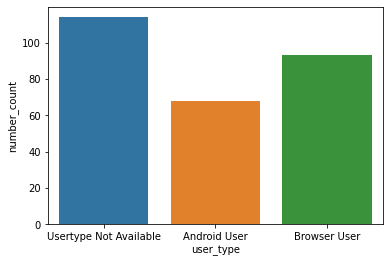

In [160]:
# creating a bar chart for better analysis

sns.barplot(x = 'user_type', y = 'number_count', data = barplot_table.toPandas())

In [162]:
# selecting rows where the users are android & browser

two_device_users = indian_users_df.select('user_name', 'text', 'user_location', 'user_description', \
                    'user_created', 'user_followers', 'user_friends', 'user_favourites', \
                    'user_verified', 'date', 'hashtags', 'user_type'). \
                    where((col('user_type') == 'Android User') | (col('user_type') == 'Browser User'))

In [163]:
two_device_users.toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,user_type
0,Hingle McCringleberry,I asked #ChatGPT for a Python script to brute-...,India,"Interests : Reading, History, Meditation, Quiz...",2008-08-13 16:19:17+00:00,671.0,1602.0,46097,False,2023-01-03 15:17:26+00:00,['ChatGPT'],Browser User
1,Chirag Juneja,Interesting Thread on applications of #ChatGPT...,India,"IT professional, Sports enthusiast, love to ea...",2009-03-09 13:30:06+00:00,139.0,253.0,7066,False,2023-01-03 10:14:32+00:00,['ChatGPT'],Browser User
2,D Naveen Kumar,The #ChatGPT helped me a lot today in document...,India,"Security Analyst, I write reports",2017-08-18 17:18:36+00:00,19.0,56.0,219,False,2023-01-03 09:24:10+00:00,['ChatGPT'],Browser User
3,Dhiraj Patra 🚴🏼,How Kindle novelists are using #ChatGPT https:...,India,#software #AI #datascience #developer #archite...,2009-02-12 11:12:34+00:00,1108.0,2768.0,7620,False,2023-01-03 07:19:46+00:00,['ChatGPT'],Browser User
4,"Cherry M P, PhD :: Wear Your Mask, Please. 🙏🏿","@olicav #ChatGPT help me understand this, please.",India,"Learns, Works, Lives, Repeat | #edtech enthusi...",2009-05-26 16:11:14+00:00,2866.0,1057.0,11132,False,2023-01-02 10:42:15+00:00,['ChatGPT'],Android User
...,...,...,...,...,...,...,...,...,...,...,...,...
156,punitvara,Advise from ChatGPT to become Billionaire in n...,India,"Sr Analyst, Machine Learning at Levi's. Opinio...",2010-11-15 10:35:03+00:00,209.0,1487.0,1213,False,2022-12-06 04:31:47+00:00,"['ChatGPT', 'Billionaire']",Browser User
157,Shrine S,One of the best uses of #ChatGPT is when you h...,India,Android dev & product guy. 1.8M+ app installs ...,2022-08-23 15:12:55+00:00,6.0,39.0,9,False,2022-12-05 19:37:00+00:00,['ChatGPT'],Android User
158,Varun Saxena,what does #ChatGPT think about @BoloLiveApp :)...,India,"Co-Founder & CEO, Bolo Live - Live Streaming P...",2010-02-13 08:01:03+00:00,1012.0,838.0,1885,False,2022-12-05 19:17:02+00:00,['ChatGPT'],Browser User
159,The Skeptical Indian,Has anyone asked #ChatGPT to explain #Tenet ?,India,"Wahi facebook vale 🙏, We are encouraging world...",2019-09-28 05:35:18+00:00,444.0,522.0,4633,False,2022-12-05 18:01:47+00:00,"['ChatGPT', 'Tenet']",Android User


#### Coming back to our main dataframe.
#### Let's do some Spark SQL!

In [127]:
# we are creating a temporary SQL table

transformed_df.createTempView('sql_table')

In [130]:
# writing a query to get users who have got more than 500 followers

spark.sql("""
SELECT user_name FROM sql_table
WHERE user_followers > 500
""").toPandas()

,user_name
0,UD College of Education & Human Development
1,SMC | LA
2,Robert Kemp
3,RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI
4,Français 🇫🇷
...,...
22123,"#chatgpt"""
22124,Property rights in #Bitcoin refer to the owner...
22125,Simone Margaritelli
22126,"#chatgpt"""


In [141]:
# query to get user names who have got more than 1000 user favourites

spark.sql("""
SELECT user_name FROM sql_table
WHERE user_favourites > 1000
""").toPandas()

,user_name
0,UD College of Education & Human Development
1,Matt Duhon
2,Domenic De Rubis
3,SMC | LA
4,Robert Kemp
...,...
18699,Grant Abt
18700,Christopher Adolphe 🇲🇺
18701,Simone Margaritelli
18702,C.C. Bangcock


In [189]:
# querying users and their device type from Germany

germany_users = spark.sql("""
SELECT user_name, user_location, 
user_type FROM sql_table
WHERE user_location = 'Germany';
""")

germany_users.toPandas()

,user_name,user_location,user_type
0,Nevertheless,Germany,Usertype Not Available
1,Ridwan Nana-Yaw Amoako 🇩🇪🇹🇷🇬🇭,Germany,Android User
2,Mohcine Chraibi,Germany,Usertype Not Available
3,Mohcine Chraibi,Germany,Usertype Not Available
4,cornflake,Germany,Browser User
...,...,...,...
96,burr,Germany,Browser User
97,XenialDan,Germany,Usertype Not Available
98,Jan Schloß,Germany,Browser User
99,Kamalkkp,Germany,Android User


In [190]:
# how many users are tweeting from Germany

print(germany_users.count(), 'users are from Germany!')

101 users are from Germany!


In [176]:
# selecting users who have the word 'AI' in their description

ai_in_description = spark.sql("""
SELECT * FROM sql_table
WHERE user_description LIKE '%AI%'
LIMIT 5;
""")

ai_in_description.toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,user_type
0,Matt Duhon,So Im building a twitter tool that used #chatg...,"Willis, TX",Currently learning everything I can about #AI ...,2011-05-03 01:38:25+00:00,168.0,474.0,5060,False,2023-01-03 20:48:01+00:00,"['chatgpt', 'API']",Browser User
1,Robert Kemp,"Alright, alright, alright! #AI #ChatGPT #IDE ...",Earth,"Fan of science and spicy food. Focused on AI,...",2009-04-02 18:24:50+00:00,2791.0,948.0,7367,False,2023-01-03 20:43:07+00:00,"['AI', 'ChatGPT', 'IDE', 'Copilot']",Browser User
2,Matt Duhon,@dumbwire Do you think there will be and impac...,"Willis, TX",Currently learning everything I can about #AI ...,2011-05-03 01:38:25+00:00,168.0,474.0,5060,False,2023-01-03 20:39:45+00:00,"['ai', 'chatgpt']",Usertype Not Available
3,AnswersByAI 🤖,Question for @OpenAI #ChatGPT 🤖 Does conscious...,United States,Official Questions and Answers by Leading AI. ...,2022-12-09 20:41:31+00:00,7.0,18.0,6,False,2023-01-03 20:29:45+00:00,['ChatGPT'],Usertype Not Available
4,𝐁𝐋𝐀𝐂𝐊 𝐋𝐀𝐁𝐄𝐋 𝐀𝐑𝐓 𝐂𝐔𝐋𝐓,@pixlosopher If that's the Openai #ChatGPT th...,"Seattle, Earth",Zealot of Valuable Artistic Expression | #Arti...,2022-05-14 02:56:14+00:00,7891.0,2442.0,32652,False,2023-01-03 20:13:50+00:00,['ChatGPT'],Browser User


In [182]:
# query for getting users who have their location as Earth :p

spark.sql("""
SELECT * FROM sql_table
WHERE user_location LIKE '%Earth%'
LIMIT 5;
""").toPandas()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,user_type
0,Robert Kemp,"Alright, alright, alright! #AI #ChatGPT #IDE ...",Earth,"Fan of science and spicy food. Focused on AI,...",2009-04-02 18:24:50+00:00,2791.0,948.0,7367,False,2023-01-03 20:43:07+00:00,"['AI', 'ChatGPT', 'IDE', 'Copilot']",Browser User
1,𝐁𝐋𝐀𝐂𝐊 𝐋𝐀𝐁𝐄𝐋 𝐀𝐑𝐓 𝐂𝐔𝐋𝐓,@pixlosopher If that's the Openai #ChatGPT th...,"Seattle, Earth",Zealot of Valuable Artistic Expression | #Arti...,2022-05-14 02:56:14+00:00,7891.0,2442.0,32652,False,2023-01-03 20:13:50+00:00,['ChatGPT'],Browser User
2,KingJrn™,My #experience with #ChatGPT has been excellen...,"Just here on Earth, for now.",Full-stack web developer and Tutor.,No Value,No Value,No Value,No Value,No Value,No Date,No Hashtags,Usertype Not Available
3,Jan Tegze,This site https://t.co/ZT2bMDALkj shows how #G...,Earth,Author: Full Stack Recruiter & https://t.co/s3...,2013-01-10 16:04:45+00:00,4422.0,1529.0,16656,False,2023-01-03 18:39:24+00:00,"['Google', 'ChatGPT']",Usertype Not Available
4,Patrick Probst,@thesamparr Have you tried enhancing any profe...,Earth,Cryptopian realist advocating for tech adoptio...,2020-02-22 13:51:20+00:00,12.0,81.0,301,False,2023-01-03 16:31:19+00:00,['ChatGPT'],Android User


In [194]:
# querying some users information who have crypto in their text

into_crypto = spark.sql("""
SELECT user_name, text, 
user_location, user_description, 
user_followers, user_type FROM sql_table
WHERE text LIKE '%crypto%'
""")

into_crypto.toPandas()

,user_name,text,user_location,user_description,user_followers,user_type
0,Benjamin,So the AI space will just be filled with bad a...,"Austin, TX",Reality has a surprising amount of detail up c...,96.0,Browser User
1,Neon Tusk,"Overall, SBF and FTX have established a reputa...",town,CEO OF TWEETR AND TOYSLA,No Value,Usertype Not Available
2,cryptoPE_,What is cryptocurrency according to ChatGPT?,No Location,No Description,No Value,Usertype Not Available
3,CryptoShlug,#AI is singlehandedly going to be the biggest ...,No Location,No Description,No Value,Usertype Not Available
4,CipherCrime,#moneylaundering #crime #cryptocurrencies #cry...,No Location,No Description,No Value,Usertype Not Available
...,...,...,...,...,...,...
444,ChatGPT,How to destroy the crypto industry via /r/weir...,No Location,Weird and creative ChatGPT / GPT-3 generations,589.0,Usertype Not Available
445,Jason Gorman @jasongorman@mastodon.cloud,We go live to crypto bros hearing about #ChatG...,"London, UK",Of @codemanship. I train and coach software de...,8975.0,Android User
446,MyEtherWallet | MEW,Even this #OpenAI chatbot knows that #selfcust...,No Location,No Description,No Value,Usertype Not Available
447,It can be useful for most fields we know,and especially in crypto.,No Location,No Description,No Value,Usertype Not Available


#### Let's write the data to a csv file

In [201]:
# converting a spark dataframe to pandas
# it works because the data is small

pd = transformed_df.toPandas()

In [202]:
# writing it to a csv file

pd.to_csv('/home/batteringram/projects/chatgpt-data-etl/transformed_tweets.csv')

## Loading the data to Postgres db

In [204]:
# we are loading the dataframe to our postgres db using jdbc connection

transformed_df.write.format('jdbc') \
              .option('url', 'jdbc:postgresql://localhost:5432/chatgpt') \
              .option('driver', 'org.postgresql.Driver') \
              .option('dbtable', 'chatgpt_data') \
              .option('user', 'postgres') \
              .option('password', 'test123') \
              .option('header', 'true') \
              .option('inferSchema', 'true') \
              .save()